### Example Notebook for FMD Analysis and b-value estimation
####   Daniel Trugman, 2024

In [1]:
### Import Packages

# imports
using DataFrames
using PyPlot
using StatsBase
using Printf
using StatSei

bval_bpos (generic function with 2 methods)

In [2]:
### Load Relocated SoCal Catalog

# load using catalog function, no minmag
qdf = load_catalog_hs2022("../data/sc_1981_2022q1_1d_3d_gc_soda.gc.gz",-10.0)

# show
qdf


Duplicates removed, keeping: 799993/800499


Row,evid,otime,tepoch,lat,lon,dep,mag,enum
,Int64,DateTime,Float64,Float64,Float64,Float64,Float64,Int64
1,3301561,1981-01-01T01:49:29.357,3.47162e8,33.7317,-118.811,6.399,2.27,1
2,3301565,1981-01-01T04:13:55.936,3.4717e8,33.2535,-115.967,6.347,2.26,2
3,3301566,1981-01-01T05:20:14.634,3.47174e8,34.1818,-117.305,5.864,2.37,3
4,3301567,1981-01-01T05:39:56.616,3.47176e8,34.1803,-117.303,5.991,1.6,4
5,3301570,1981-01-01T08:23:18.236,3.47185e8,34.0078,-117.163,15.468,1.88,5
6,3301572,1981-01-01T10:57:34.740,3.47195e8,34.0952,-117.305,16.052,1.4,6
7,3301576,1981-01-01T15:05:24.663,3.4721e8,35.3118,-118.555,8.348,2.16,7
8,3301578,1981-01-01T17:45:59.091,3.47219e8,33.5046,-116.765,6.05,1.5,8
9,12249959,1981-01-01T18:57:18.490,3.47223e8,33.5688,-117.78,16.38,1.85,9


Mc: 1.3


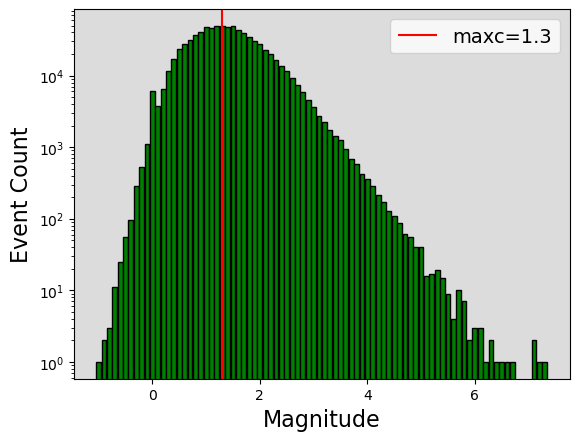

In [3]:
### View Frequency-Magnitude distribution

# compute fmd
counts, bins = fmd(qdf.mag,0.1)

# compute magnitude of completion via max. curvature (will be biased)
mc = mc_maxc(qdf.mag)
@printf("Mc: %.1f\n",mc)

# figure setup
fig, axi = plt.subplots()
axi.set_facecolor("gainsboro")

# plot FMD
axi.bar(x=bins,height=counts,log=true,width=0.09,
    edgecolor="k",color="green");

# plot Mc
axi.vlines(x=mc,ymin=axi.get_ylim()[1],
    ymax=axi.get_ylim()[2],color="r",label=@sprintf("maxc=%.1f",mc))

# formatting
axi.legend(loc="upper right",fontsize=14)
axi.set_xlabel("Magnitude",fontsize=16)
axi.set_ylabel("Event Count",fontsize=16);

 26.266149 seconds (1.32 M allocations: 50.605 GiB, 4.98% gc time, 1.25% compilation time)
max-likelihood estimate: 0.942
bootstrap median: 0.942
95pct confidence: 0.938 0.947


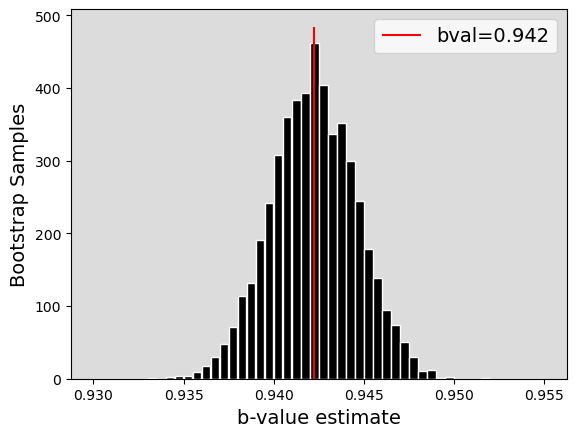

In [4]:
### b-value estimation: maximum likelihood method

# compute b-value
mprec = 0.01 # magnitude precision
mc_est = 2.0 # conservative mc estimate
mags = qdf.mag # as an array
bval = bval_maxl(mags,mprec,mc_est) # max-likelihood estimate

# bootstrapping
nxc = length(qdf.mag)
ixc = Vector{Int32}(1:nxc) # sampling index
nboot = 5000
bvals = zeros(nboot)
@time Threads.@threads for ib in 1:nboot
    data = mags[sample(ixc,nxc,replace=true)]
    bvals[ib] = bval_maxl(data,mprec,mc_est)
end

# summary statistics
bqu = quantile(bvals,[0.025,0.5,0.975])
@printf("max-likelihood estimate: %.3f\n",bval)
@printf("bootstrap median: %.3f\n",bqu[2])
@printf("95pct confidence: %.3f %.3f\n",bqu[1],bqu[3])

# plot to check
fig, axi = plt.subplots()
axi.set_facecolor("gainsboro")
axi.hist(bvals[1:end],0.930:0.0005:0.955,color="k",
    width=0.00048,edgecolor="w");
axi.vlines(x=bval,ymin=axi.get_ylim()[1],
    ymax=axi.get_ylim()[2],color="r",label=@sprintf("bval=%.3f",bval))

# plot formatting
axi.set_xlabel("b-value estimate",fontsize=14)
axi.legend(fontsize=14)
axi.set_ylabel("Bootstrap Samples",fontsize=14);


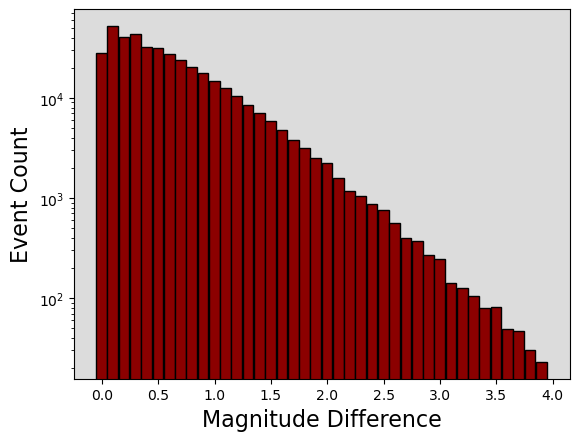

In [5]:
### Examine Magnitude Differences
#  - should look exponential, but the rolloff at low dM indicates incompleteness

# compute positive magnitude differences
# - note that the catalog is temporally sorted!
dmags = round.(diff(mags),digits=2)
dmags = dmags[dmags .>= 0.0]

# figure setup
fig, axi = plt.subplots()
axi.set_facecolor("gainsboro")

# make a histogram
dbin = 0.1
binE = collect(0.0:dbin:4.0) .- dbin/2.0
axi.hist(dmags,binE,width=0.95*dbin,edgecolor="k",log=true,color="darkred")

# plot formatting
axi.set_xlabel("Magnitude Difference",fontsize=16)
axi.set_ylabel("Event Count",fontsize=16);


  2.760877 seconds (83.30 k allocations: 7.151 GiB, 6.58% gc time, 1.14% compilation time)
     b+ estimate: 0.919
bootstrap median: 0.919
95pct confidence: 0.913 0.925


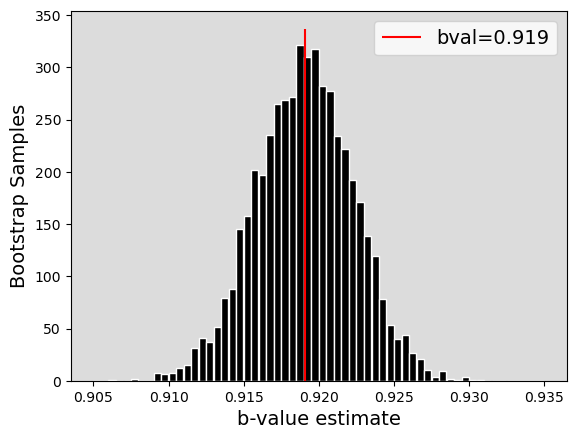

In [6]:
### B-value with b-positive approach (without precision correction)
# - this is *not* an ideal case study because of the large spatial area...

# set parameters
dmc = 1.0 # this is quite conservative
dmagsC = dmags[dmags.>=dmc] # cut for efficiency
bval = bval_bpos(dmagsC,dmc) # b+ estimate

# bootstrapping
nxc = length(dmagsC)
ixc = Vector{Int32}(1:nxc) # sampling index
nboot = 5000
bvals = zeros(nboot)
@time Threads.@threads for ib in 1:nboot
    data = dmagsC[sample(ixc,nxc,replace=true)]
    bvals[ib] = bval_bpos(data,dmc)
end

# summary statistics
bqu = quantile(bvals,[0.025,0.5,0.975])
@printf("     b+ estimate: %.3f\n",bval)
@printf("bootstrap median: %.3f\n",bqu[2])
@printf("95pct confidence: %.3f %.3f\n",bqu[1],bqu[3])

# setup plot to check
fig, axi = plt.subplots()
axi.set_facecolor("gainsboro")

# plot bootstrapping and estimate
axi.hist(bvals[1:end],0.905:0.0005:0.935,color="k",
    width=0.00048,edgecolor="w");
axi.vlines(x=bval,ymin=axi.get_ylim()[1],
    ymax=axi.get_ylim()[2],color="r",label=@sprintf("bval=%.3f",bval))

# plot formatting
axi.set_xlabel("b-value estimate",fontsize=14)
axi.legend(fontsize=14)
axi.set_ylabel("Bootstrap Samples",fontsize=14);

  2.780217 seconds (83.31 k allocations: 7.151 GiB, 6.87% gc time, 1.14% compilation time)
     b+ estimate: 0.909
bootstrap median: 0.910
95pct confidence: 0.903 0.916


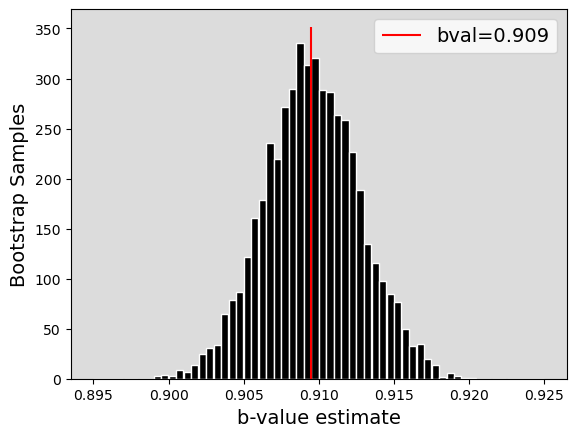

In [7]:
### B-value with b-positive approach, with precision correction
# - this is *not* an ideal case study because of the large spatial area...

# set parameters
dmprec = 0.01 # precision of catalog
dmc = 1.0 # this is quite conservative
dmagsC = dmags[dmags.>=dmc] # cut for efficiency
bval = bval_bpos(dmagsC,dmprec,dmc) # b+ estimate

# bootstrapping
nxc = length(dmagsC)
ixc = Vector{Int32}(1:nxc) # sampling index
nboot = 5000
bvals = zeros(nboot)
@time Threads.@threads for ib in 1:nboot
    data = dmagsC[sample(ixc,nxc,replace=true)]
    bvals[ib] = bval_bpos(data,dmprec,dmc)
end

# summary statistics
bqu = quantile(bvals,[0.025,0.5,0.975])
@printf("     b+ estimate: %.3f\n",bval)
@printf("bootstrap median: %.3f\n",bqu[2])
@printf("95pct confidence: %.3f %.3f\n",bqu[1],bqu[3])

# setup plot to check
fig, axi = plt.subplots()
axi.set_facecolor("gainsboro")

# plot bootstrapping and estimate
axi.hist(bvals[1:end],0.895:0.0005:0.925,color="k",
    width=0.00048,edgecolor="w");
axi.vlines(x=bval,ymin=axi.get_ylim()[1],
    ymax=axi.get_ylim()[2],color="r",label=@sprintf("bval=%.3f",bval))

# plot formatting
axi.set_xlabel("b-value estimate",fontsize=14)
axi.legend(fontsize=14)
axi.set_ylabel("Bootstrap Samples",fontsize=14);